#Borzoi Inference: Using a Borzoi model to make predictions on a single-sequence from UCSC Genome Browser
Author: Noah Dreifus

Date: 12/9/2024

**Paper Citation:**
Linder, J., Srivastava, D., Yuan, H., Agarwal, V., & Kelley, D. R. (2023). Predicting RNA-seq coverage from DNA sequence as a unifying model of gene regulation. bioRxiv. https://doi.org/10.1101/2023.08.30.555582

**Github Link:** https://github.com/Genentech/gReLU/tree/main

In [31]:
# Import neccessary libraries
import numpy as np
import pandas as pd
import torch
import os

In [32]:
# Install grelu
!pip install grelu

In [33]:
import grelu.resources

##Load the pre-trained Borzoi model from the model zoo
From the `grelu.resources` module we will load the Borzoi model (https://www.biorxiv.org/content/10.1101/2023.08.30.555582v1) trained to predict thousands of human genomic tracks from sequence. Here we are using the 3rd version of the Borzoi model indicated by the human_fold2 model name.

In [34]:
model = grelu.resources.load_model(
    project="Borzoi",
    model_name="human_fold2",
)

wandb: Currently logged in as: anony-moose-119100779392768193. Use `wandb login --relogin` to force relogin
wandb: Downloading large artifact human_fold2:latest, 711.00MB. 1 files... 
wandb:   1 of 1 files downloaded.  
Done. 0:0:0.9


##Viewing Borzoi Model 3 Metadata
Printing metadata fields about the data used to train the Borzoi Model

In [35]:
model.data_params.keys()

dict_keys(['tasks', 'train_seq_len', 'train_label_len', 'train_genome', 'train_bin_size'])

In [36]:
for key in model.data_params.keys():
    if key !="tasks":
        print(key, model.data_params[key])

train_seq_len 524288
train_label_len 16384
train_genome hg38
train_bin_size 32


In [37]:
tasks = pd.DataFrame(model.data_params['tasks'])
tasks.head(3)

,name,file,clip,clip_soft,scale,sum_stat,strand_pair,description,assay,sample
0,CNhs10608+,/home/drk/tillage/datasets/human/cage/fantom/C...,768,384,1.0,sum,1,CAGE:Clontech Human Universal Reference Total ...,CAGE,"Clontech Human Universal Reference Total RNA, ..."
1,CNhs10608-,/home/drk/tillage/datasets/human/cage/fantom/C...,768,384,1.0,sum,0,CAGE:Clontech Human Universal Reference Total ...,CAGE,"Clontech Human Universal Reference Total RNA, ..."
2,CNhs10610+,/home/drk/tillage/datasets/human/cage/fantom/C...,768,384,1.0,sum,3,CAGE:SABiosciences XpressRef Human Universal T...,CAGE,SABiosciences XpressRef Human Universal Total ...


##Make Genomic Inference Interval
Picking the coordinations of where PIK3CA gene is located on chromosome 3 in the human genome using UCSC Genome Browser on human hg38 genome. Since the model was trained on sequences of length 524288 bp, our input interval will be of the same length.


In [38]:
input_len = model.data_params["train_seq_len"]
chrom = "chr3"
input_start = 179145322
input_end = input_start + input_len

In [39]:
input_intervals = pd.DataFrame({
    'chrom':[chrom], 'start':[input_start], 'end':[input_end], "strand":["+"],
})

input_intervals

,chrom,start,end,strand
0,chr3,179145322,179669610,+


##Extracting the Sequence
Converting the genomic interval to a string using the `grelu.sequence.format` function.

In [40]:
import grelu.sequence.format

# Converting input type
input_seqs = grelu.sequence.format.convert_input_type(
    input_intervals,
    output_type="strings",
    genome="hg38"
)
input_seq = input_seqs[0]

# Printing length of sequence to check if same size as what the model was trained on: PASSED
len(input_seq)

524288

##Run inference on a single sequence

Using `model.predict_on_seqs` from gReLu to allow the model to make predictions on a single DNA sequence.

In [41]:
%%time
preds = model.predict_on_seqs(input_seqs, device=0)

# Looking at the shape of the predictions
preds.shape

CPU times: user 698 ms, sys: 5.35 ms, total: 703 ms
Wall time: 663 ms


(1, 7611, 6144)

The shape of the predictions named `preds` is in the format `Batch, Tasks, Length`. Therefore we have 1 sequence, 7611 tasks, and 6144 bins along the length axis.

##Get output interval coordinates
We can find out the region for which Borzoi is making predictions using the `input_intervals_to_output_intervals` method.

In [42]:
output_intervals = model.input_intervals_to_output_intervals(input_intervals)
output_intervals

,chrom,start,end,strand
0,chr3,179309162,179505770,+


In [43]:
output_start = output_intervals.start[0]
output_end = output_intervals.end[0]
output_len = output_end - output_start
# Printing the length of the sequence Borzoi is making predictions on
print(output_len)

196608


We see that our predictions encompass the central 196608 bp of the input 524288 bp.

##Plotting Predictions using `grelu.visualize`
Visualizing the Borzoi predictions over the output region. We will visualize the first 2 CAGE-seq and RNA-seq output tracks for Lung Tissue.

CAGE-Seq measures RNA expression and maps TSS in promoters.
RNA-Seq measures the quantity and presence of RNA molecules

In [44]:
import grelu.visualize
%matplotlib inline

In [59]:
# Investigating lung tissue specificity
cage_lung_tasks = tasks[(tasks.assay=="CAGE") & (tasks["sample"].str.contains("lung"))].head(2)
rna_lung_tasks = tasks[(tasks.assay=="RNA") & (tasks["sample"].str.contains("lung"))].head(2)

tasks_to_plot = cage_lung_tasks.index.tolist() + rna_lung_tasks.index.tolist()
task_names = tasks.description[tasks_to_plot].tolist() # Description of these tracks from the `tasks` dataframe

print(tasks_to_plot)
print(task_names)

[24, 25, 6096, 6097]
['CAGE:lung, adult, pool1', 'CAGE:lung, adult, pool1', 'RNA:fibroblast of lung female adult (83 years) and male adult (23 years)', 'RNA:fibroblast of lung female adult (83 years) and male adult (23 years)']


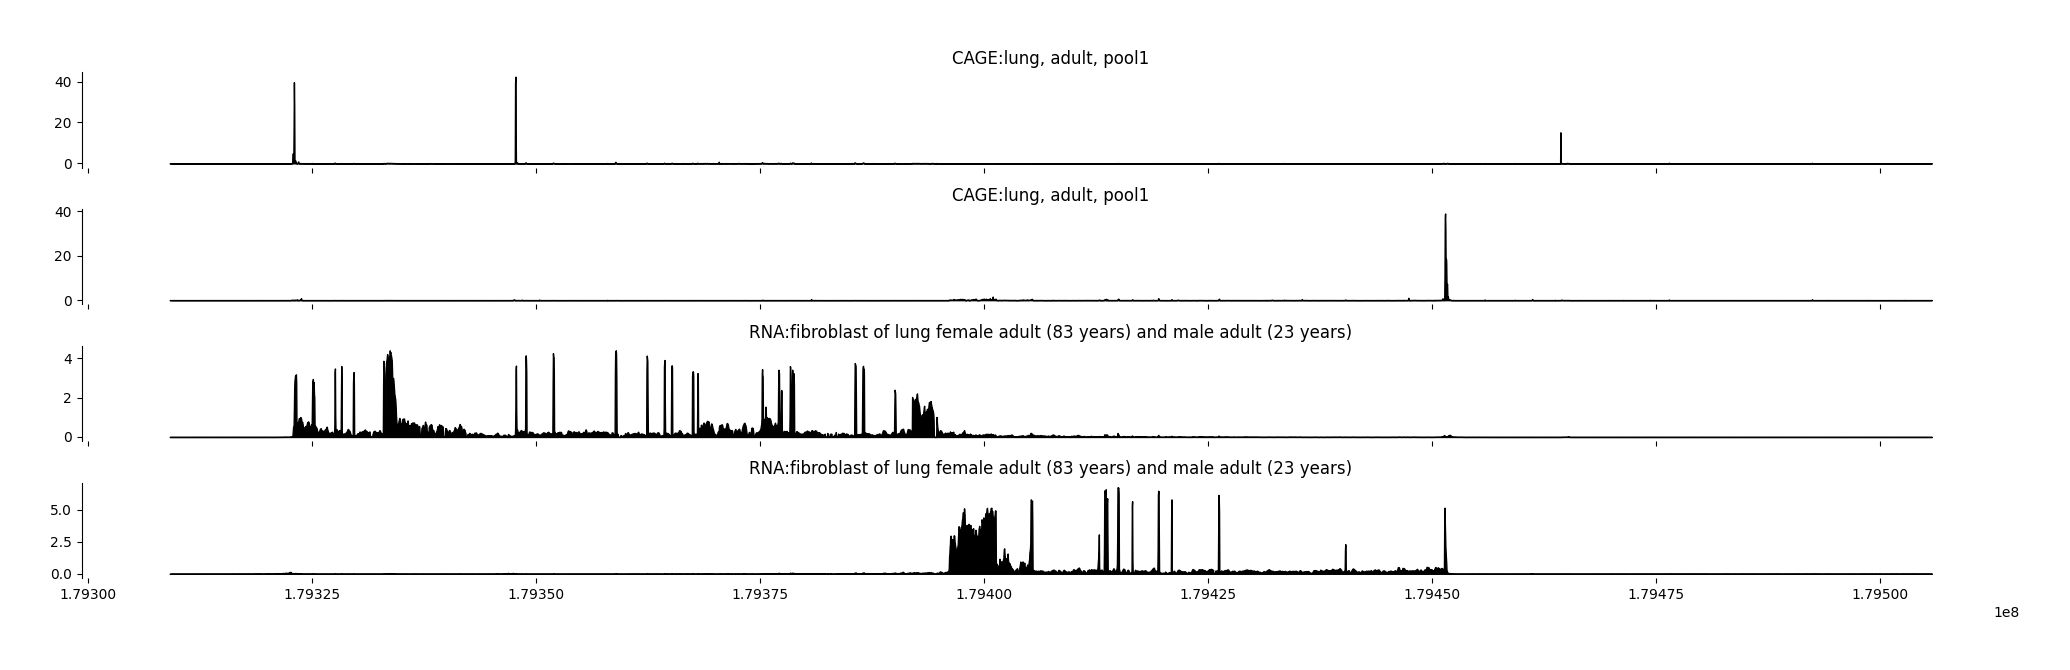

In [60]:
fig = grelu.visualize.plot_tracks(
    preds[0, tasks_to_plot, :], # Outputs to plot
    start_pos=output_start, # Start coordinate for the x-axis label
    end_pos=output_end, # End coordinate for the x-axis label
    titles=task_names, # titles for each track
    figsize=(20, 6), # width, height
)

##Adding Genomic Annotations
We can also extract genomic annotations and visualize them alongside the predicted activity.

Installing UCSC tools to access annotations.

In [54]:
!rsync -aP rsync://hgdownload.soe.ucsc.edu/genome/admin/exe/linux.x86_64/genePredToBed /usr/bin/
!rsync -aP rsync://hgdownload.soe.ucsc.edu/genome/admin/exe/linux.x86_64/genePredToGtf /usr/bin/
!rsync -aP rsync://hgdownload.soe.ucsc.edu/genome/admin/exe/linux.x86_64/bedToGenePred /usr/bin/
!rsync -aP rsync://hgdownload.soe.ucsc.edu/genome/admin/exe/linux.x86_64/gtfToGenePred /usr/bin/
!rsync -aP rsync://hgdownload.soe.ucsc.edu/genome/admin/exe/linux.x86_64/gff3ToGenePred /usr/bin/

receiving incremental file list
receiving incremental file list
receiving incremental file list
receiving incremental file list
receiving incremental file list


Extracting the coordinates for exons in the hg38 human genome:

In [55]:
import grelu.io.genome

exons = grelu.io.genome.read_gtf("hg38", features="exon")
exons.head(3) #Outputting first 3 exon results

,chrom,start,end,gene_name,source,feature,score,strand,frame,attribute
1,chr1,11874,12227,DDX11L1,genomepy,exon,.,+,.,"gene_id ""DDX11L1""; transcript_id ""NR_046018.2""..."
2,chr1,12613,12721,DDX11L1,genomepy,exon,.,+,.,"gene_id ""DDX11L1""; transcript_id ""NR_046018.2""..."
3,chr1,13221,14409,DDX11L1,genomepy,exon,.,+,.,"gene_id ""DDX11L1""; transcript_id ""NR_046018.2""..."


Filtering those exons that overlap with the output region we are predicting:

In [56]:
import grelu.data.preprocess

output_exons = grelu.data.preprocess.filter_overlapping(
    exons,
    ref_intervals=output_intervals,
    method="any" # return the exon if there any overlap at all with the output interval
)
# Viewing first 3 exons that were returned from the filtering in our output region which we are predicting
output_exons.head(3)

Keeping 193 intervals


,chrom,start,end,gene_name,source,feature,score,strand,frame,attribute
2949441,chr3,179322876,179322960,ZNF639,genomepy,exon,.,+,.,"gene_id ""ZNF639""; transcript_id ""NM_001375806...."
2949442,chr3,179325042,179325322,ZNF639,genomepy,exon,.,+,.,"gene_id ""ZNF639""; transcript_id ""NM_001375806...."
2949443,chr3,179327561,179327631,ZNF639,genomepy,exon,.,+,.,"gene_id ""ZNF639""; transcript_id ""NM_001375806...."


This gives us all the exon coordinates in the output region. Since some of these exons may exceed the output region, we clip the start and end values to the output interval coordinates.

In [57]:
output_exons = grelu.data.preprocess.clip_intervals(output_exons, start=output_start, end=output_end)
output_exons.head(3) #Again only outputting the first 3 cropped exons in our prediction region

,chrom,start,end,gene_name,source,feature,score,strand,frame,attribute
2949441,chr3,179322876,179322960,ZNF639,genomepy,exon,.,+,.,"gene_id ""ZNF639""; transcript_id ""NM_001375806...."
2949442,chr3,179325042,179325322,ZNF639,genomepy,exon,.,+,.,"gene_id ""ZNF639""; transcript_id ""NM_001375806...."
2949443,chr3,179327561,179327631,ZNF639,genomepy,exon,.,+,.,"gene_id ""ZNF639""; transcript_id ""NM_001375806...."


We also want to annotate each gene, so we create a dataframe called genes that spans the region from the start of the first exon to the end of the last exon for each gene.

In [58]:
output_genes = grelu.data.preprocess.merge_intervals_by_column(
    output_exons, group_col="gene_name"
)
output_genes

,gene_name,chrom,start,end
0,GNB4,chr3,179396088,179451470
1,MFN1,chr3,179347709,179394936
2,ZNF639,chr3,179322876,179338583


##Plotting predictions with annotations

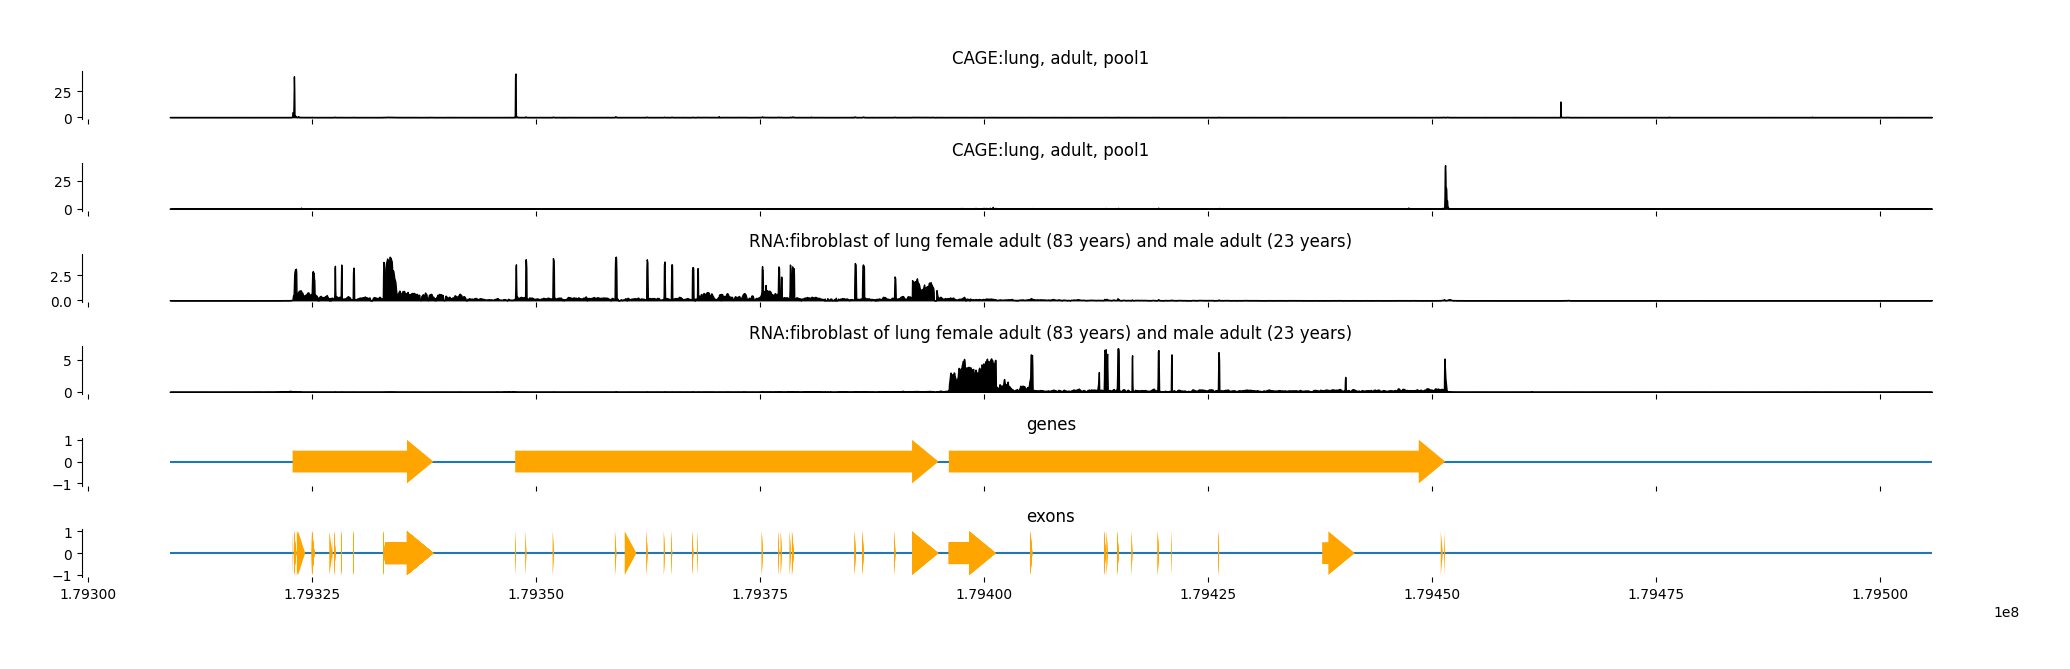

In [61]:
fig2 = grelu.visualize.plot_tracks(
    preds[0, tasks_to_plot, :], # Outputs to plot
    start_pos=output_start, # Start coordinate for x-axis
    end_pos=output_end, # End coordinate for x-axis
    titles=task_names,
    figsize=(20, 6),
    annotations={"genes":output_genes, "exons":output_exons} # Dictionary of annotation dataframes
)

#Analyzing Attention Weights
Here, we can analyze the attention weights with Borzoi's transformer layers to see the relationships between local sequence regions. We use the `grelu.interpret.score` module which contains functions to score the importance of input bases.

In [24]:
import grelu.interpret.score

attn = grelu.interpret.score.get_attention_scores(
    model=model,
    seqs=input_seq,
    genome='hg38',
    block_idx=-1, # Taking attention weights from the final transformer layer
)

attn.shape

(8, 4096, 4096)

The shape of `attn` is in the form (heads, bins, bins). The first dimension is of length 8 since the transformer layer contains 8 heads. We will average the weights of all heads together to get a single bin x bin matrix.

In [25]:
attn = attn.mean(0)
attn.shape

(4096, 4096)

Collecting the gene annotations before visualizing the matrix. Since the attention matrix is obtained from the transformer layers before cropping, it corresponds to the 524 kb input interval, not the 196 kb output interval. So, we once again extract exons and genes, this time overlapping with the input interval.

In [63]:
input_exons = grelu.data.preprocess.filter_overlapping(
    exons,
    ref_intervals=input_intervals,
    method="any" # return the exon if there is any overlap at all with the output interval.
)
input_exons = grelu.data.preprocess.clip_intervals(input_exons, start=output_start, end=output_end)
input_genes = grelu.data.preprocess.merge_intervals_by_column(
    input_exons.iloc[:, :4], group_col="gene_name"
)
# Printing gene annotations in the input layer
input_genes

Keeping 343 intervals


,gene_name,chrom,start,end
0,ACTL6A,chr3,179562926,179505770
1,GNB4,chr3,179396088,179505770
2,KCNMB3,chr3,179309162,179267050
3,LOC124900560,chr3,179309162,179169210
4,LOC124906348,chr3,179614775,179505770
5,LOC124909462,chr3,179571523,179505770
6,MFN1,chr3,179347709,179394936
7,MRPL47,chr3,179588285,179505770
8,NDUFB5,chr3,179604794,179505770
9,PIK3CA,chr3,179309162,179240093


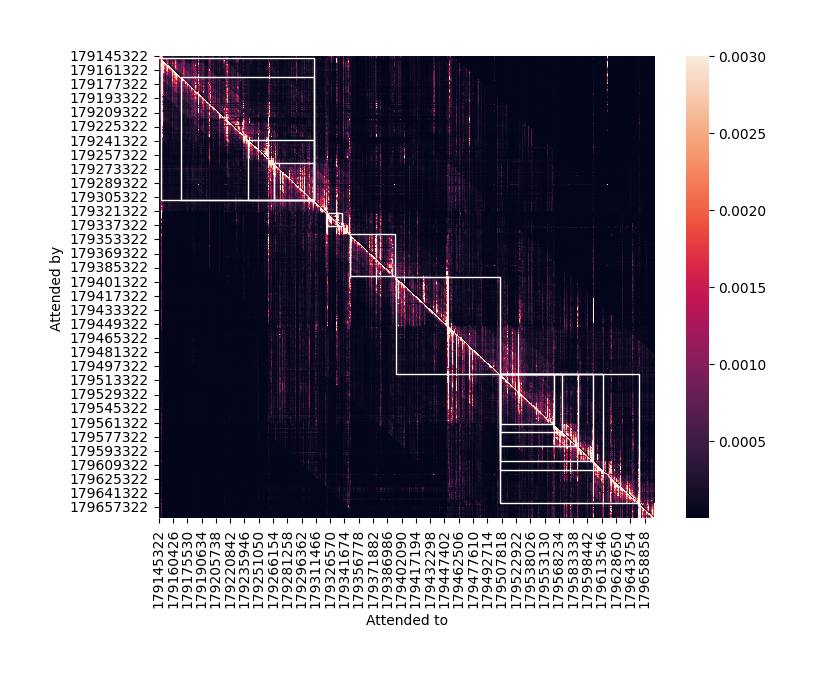

In [27]:
fig3 = grelu.visualize.plot_attention_matrix(
    attn,
    start_pos=input_start,
    end_pos=input_end,
    highlight_intervals=input_genes, # Draw a box around each gene
    vmax=0.003,
    figsize=(8, 6)
)

#Calculate tissue specific expression over PIK3CA exons
Interested in the specific function of the total RNA-seq expression over all exons of the PIK3CA gene as well as the tissue specificity of this expression, in breast vs. lung. We first identify the relevant tasks in the model's predictions.

In [28]:
breast_tasks = tasks[(tasks.assay == "RNA") & (tasks["sample"].str.contains("breast"))].index.tolist()
print(breast_tasks)

[6445, 6446, 6553, 6554, 6558, 6559, 6826, 6827, 6834, 6835, 7542, 7543, 7544]


In [29]:
lung_tasks = tasks[(tasks.assay == "RNA") & (tasks["sample"].str.contains("lung"))].index.tolist()
print(lung_tasks)

[6096, 6097, 6098, 6099, 6148, 6149, 6238, 6239, 6339, 6395, 6396, 6397, 6431, 6482, 6483, 6542, 6575, 6643, 6644, 6677, 6678, 6784, 6785, 6792, 6793, 6812, 6813, 6846, 6847, 6905, 6906, 6907, 6973, 6983, 7003, 7022, 7023, 7024, 7050, 7051, 7187, 7188, 7203, 7293, 7294, 7295, 7296, 7313, 7314, 7326, 7327, 7364, 7405, 7406, 7434, 7435, 7566, 7567, 7568]


##Looking at what these tasks are

In [30]:
tasks.iloc[breast_tasks].head(3)

,name,file,clip,clip_soft,scale,sum_stat,strand_pair,description,assay,sample
6445,ENCFF863UAA+,/home/drk/tillage/datasets/human/rna/encode/EN...,768,384,0.3,sum_sqrt,6446,RNA:breast epithelium tissue male adult (37 ye...,RNA,breast epithelium tissue male adult (37 years)
6446,ENCFF863UAA-,/home/drk/tillage/datasets/human/rna/encode/EN...,768,384,0.3,sum_sqrt,6445,RNA:breast epithelium tissue male adult (37 ye...,RNA,breast epithelium tissue male adult (37 years)
6553,ENCFF046XIT+,/home/drk/tillage/datasets/human/rna/encode/EN...,768,384,0.3,sum_sqrt,6554,RNA:fibroblast of breast female adult (17 years),RNA,fibroblast of breast female adult (17 years)


In [31]:
tasks.iloc[lung_tasks].head(3)

,name,file,clip,clip_soft,scale,sum_stat,strand_pair,description,assay,sample
6096,ENCFF556PAF+,/home/drk/tillage/datasets/human/rna/encode/EN...,768,384,0.3,sum_sqrt,6097,RNA:fibroblast of lung female adult (83 years)...,RNA,fibroblast of lung female adult (83 years) and...
6097,ENCFF556PAF-,/home/drk/tillage/datasets/human/rna/encode/EN...,768,384,0.3,sum_sqrt,6096,RNA:fibroblast of lung female adult (83 years)...,RNA,fibroblast of lung female adult (83 years) and...
6098,ENCFF618FQK+,/home/drk/tillage/datasets/human/rna/encode/EN...,768,384,0.3,sum_sqrt,6099,RNA:lung microvascular endothelial cell female...,RNA,lung microvascular endothelial cell female adu...


##Getting the coordinates of the exons of the PIK3CA gene.

In [32]:
PIK3CA_exons = exons[exons.gene_name == "PIK3CA"]
PIK3CA_exons.head(3)

,chrom,start,end,gene_name,source,feature,score,strand,frame,attribute
2949291,chr3,179148126,179148219,PIK3CA,genomepy,exon,.,+,.,"gene_id ""PIK3CA""; transcript_id ""XM_006713658...."
2949292,chr3,179198750,179199177,PIK3CA,genomepy,exon,.,+,.,"gene_id ""PIK3CA""; transcript_id ""XM_006713658...."
2949294,chr3,179199690,179199899,PIK3CA,genomepy,exon,.,+,.,"gene_id ""PIK3CA""; transcript_id ""XM_006713658...."


In order to get the predicted coverage over the PIK3CA exons, we need to identify the relevant bins in the output track that overlap with exons of PIK3CA. Grelu has another coordinate-conversion function for this:

In [33]:
PIK3CA_exon_bins = model.input_intervals_to_output_bins(
    intervals=PIK3CA_exons,
    start_pos=input_start # Start coordinate of the input sequence
)
PIK3CA_exon_bins.head(3)

,start,end
2949291,-5033,-5029
2949292,-3451,-3437
2949294,-3421,-3414


We now have the indices of all the bins that overlap with each exon, time to overlap them

In [34]:
selected_bins = set()
for row in PIK3CA_exon_bins.itertuples():
    selected_bins = selected_bins.union(list(range(row.start, row.end)))

selected_bins = list(selected_bins)

print(len(selected_bins))

309


Out of the 6144 bins in the model's output, we are interested in only 309 of them. Now, we can use the `grelu.transforms` module to define a transform or objective function that calculates a specific score from the model's predictions.

We use the Specificity transform since we are computing the difference between on- and off- target tasks.

In [35]:
import grelu.transforms.prediction_transforms

lung_specific_PIK3CA_score = grelu.transforms.prediction_transforms.Specificity(
    on_tasks = lung_tasks, # positive tasks
    off_tasks = breast_tasks, # negative tasks
    positions = selected_bins, # The relevant regions of the output
    on_aggfunc = "mean", # Average expression over the positive tasks
    off_aggfunc = "mean", # Average expression over the negative tasks
    length_aggfunc = "mean", # Average expression over the bins
    compare_func = "divide", # Return the ratio of expression in positive tasks to negative tasks
)

By applying this function to our model's predictions, we get the ratio between the mean expression in exons of PIK3CA in breast RNA-seq tracks vs. in lung RNA-seq tracks.

In [36]:
lung_specific_PIK3CA_score.compute(preds)

array([[[1.3478884]]], dtype=float32)

The total expression over all annotated PIK3CA exons is on average 1.35x higher in lung RNA-seq tracks than breast RNA-seq tracks.

#ISM with respect to specific expression
We can perform In Silico Mutagenesis (ISM) to identify which bases in the input sequence are contributing to the tissue-specific expression. Since ISM on all 524288 bases would take a long time, we will take 100 bases upstream and downstream of the start position of the first exon. The `ISM_predict` function in `grelu.interpret.score` performs every possible single-base substitution on the given sequence, predicts the effect of each substitution, and optionally compares these predictions to the reference sequence to return an effect size for each substitution.

We are interested in performing ISM on the PIK3CA gene, we will use PIK3CA's first exon.




In [37]:
ism_start_pos = PIK3CA_exons.start.min() - 100
ism_end_pos = PIK3CA_exons.start.min() + 100
print(ism_start_pos, ism_end_pos)

179148026 179148226


In [39]:
%%time

ism = grelu.interpret.score.ISM_predict(
    seqs=input_seq,
    model=model,
    prediction_transform=lung_specific_PIK3CA_score, # We will compute how each base affects this score
    devices=0, # Index of the GPU to use
    batch_size=8,
    num_workers=1,
    start_pos=ism_start_pos-input_start, # Relative start position from the first base
    end_pos=ism_end_pos-input_start, # Relative end position from the first base
    return_df=True, # Return a dataframe
    compare_func="log2FC", # Return the log2 ratio between the predictions for the mutated sequence and the reference sequence (aka the score of each nucleotide)
)

ism.shape

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

CPU times: user 1min 39s, sys: 2.52 s, total: 1min 41s
Wall time: 1min 41s


(4, 200)

The output here is a dataframe with 4 rows corresponding to the bases that were substituted at each position (A, C, G and T) and 200 columns, one for each position that was mutated. Because we selected `compare_func="log2FC"`, the values in the dataframe represent log (score of mutated sequence / score of original sequence).

In [41]:
#ISM scores
ism.iloc[:, :5]

,A,G,G,C,G
A,0.000000,-0.000028,-0.000160,-4.966854e-04,-0.000531
C,-0.000168,-0.000113,-0.000307,-2.579740e-07,-0.000445
G,-0.000421,0.000000,0.000000,-8.838315e-04,0.000000
T,-0.000345,-0.000094,-0.000456,-9.434613e-04,-0.000408


<Axes: >

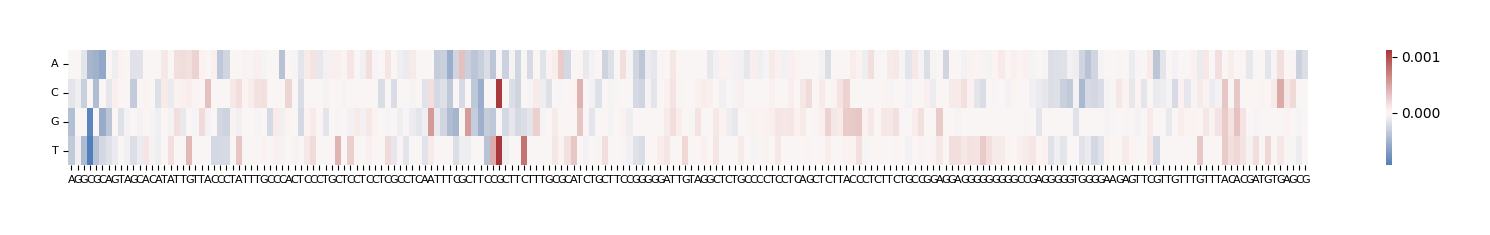

In [42]:
#Visualizing ISM Scores: Heatmap
grelu.visualize.plot_ISM(ism, method="heatmap", figsize=(20, 1.5), center=0)

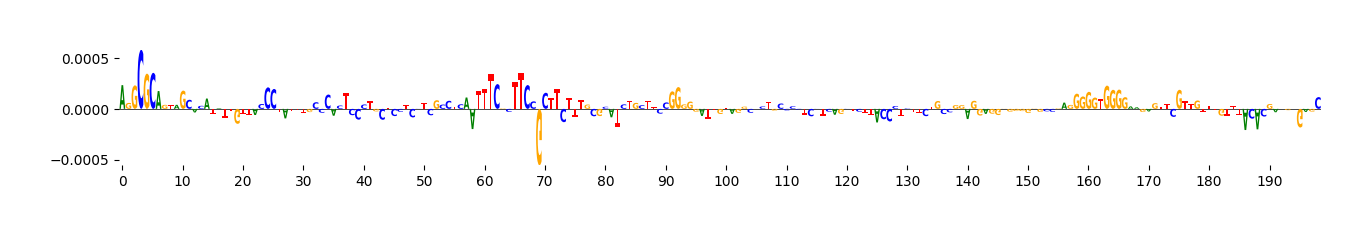

In [43]:
#Visualizing ISM Scores: Sequence logo where the height of each base corresponds to its importance.
grelu.visualize.plot_ISM(ism, method="logo", figsize=(15.5, 1.5))